In [201]:
import pandas as pd
import numpy as np


# Cargar base de datos de pickle
df = pd.read_pickle("data/df.pkl")

In [202]:
df = df.rename(columns={"Precio_Utilización": "target"})

# Gráfica de barras
import plotly.express as px

fig = px.bar(
    df.groupby("Reclamacion_Desc")["target"].mean().sort_values(ascending=False),
    x="target",
    title="Precio promedio por Reclamación",
    labels={"Reclamacion_Desc": "Motivo reclamación", "target": "Precio promedio"},
    color_discrete_sequence=px.colors.sequential.RdBu,
)
fig.show()

# Preprocesamiento

Se eliminaran las siguientes columnas

No aporta información al modelo:
* Afiliado_Id
* Fecha_Reclamacion
* FECHA_INICIO
* FECHA_FIN

No son útiles para el tarifario (datos que no se piden al cliente)
* Cantidad_Utilizaciones: El 87% es 1 entonces el modelo no aprenderá nada 
* Costo_Total_Utilizaciones: Sacaremos el tarifario con el precio unitario
* Diagnostico_Desc: Tomaremos solo la variable reclamación para justificar el precio del seguro médico
* Días_en_reclamar: Tomaremos solo la variable reclamación para justificar el precio del seguro médico

La columna tiene otra relacionada
* Edad: Tenemos rango de edad

También unimos de la variable Reclamacion_Desc Donacion de organos y conciliacion como Otros, ya que tenían muy pocos registros y daba problemas al hacer el split de train y test

Y para el otro dataframe quitamos las mismas excepto Afiliado ID para poder filtrar en el otro dataframe los expuestos

In [203]:
###################### QUITAR COLUMNAS QUE NO SE VAN A UTILIZAR ######################
###################### Renombre y copia del df ######################

# Copia del df para el final
df1 = df.copy()

# Quitar columnas que no se van a utilizar
df = df.drop(
    [
        "Afiliado_Id",
        "Fecha_Reclamacion",
        "FECHA_INICIO",
        "FECHA_FIN",
        "Días_en_reclamar",
        "Cantidad_Utilizaciones",
        "Costo_Total_Utilizaciones",
        "Diagnostico_Desc",
        "Edad",
    ],
    axis=1,
)

# Quitar columnas que no se van a utilizar pero para el dataset final necesitamos saber el Afiliado ID
df1 = df1.drop(
    [
        "Fecha_Reclamacion",
        "FECHA_INICIO",
        "FECHA_FIN",
        "Días_en_reclamar",
        "Cantidad_Utilizaciones",
        "Costo_Total_Utilizaciones",
        "Diagnostico_Desc",
        "Edad",
    ],
    axis=1,
)


# Unir conciliacion y donacion de organos de reclamacion_Desc como "otros"
df["Reclamacion_Desc"] = df["Reclamacion_Desc"].replace(
    [
        "CONCILIACION",
        "DONACION DE ORGANOS",
    ],
    "OTROS",
)

In [62]:
######################## PREPROCESAMIENTO MODELADO ########################
# Separación de caracteristicas y target (X , y)
from sklearn.model_selection import train_test_split

y = df.target
X = df.drop(["target"], axis=1)


# Separación en conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


# Mostrar los tamaños de los conjuntos
print("Tamaño de X_train: ", X_train.shape)
print("Tamaño de X_test: ", X_test.shape)


# Seleccionar variables numéricas int64 y float64 y categóricas object
# numeric_columns = list(X.select_dtypes(include=["int64", "float64"]).columns)
categorical_columns = list(X.select_dtypes(include=["object", "category"]).columns)


# Estandarizar las variables numéricas
from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler()
# X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
# X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])


# Convertir a dummy las variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

Tamaño de X_train:  (446439, 9)
Tamaño de X_test:  (191331, 9)


# Modelos

MÉTRICA:

En el contexto del número de costo utilizaciones de un seguro en el sector salud, es esencial considerar la presencia de valores extremos. Estos valores pueden surgir debido a una serie de factores, como la atención médica intensiva necesaria para pacientes con condiciones médicas excepcionalmente graves o complejas.

La presencia de valores extremos es lógica en este contexto, ya que reflejan situaciones donde los pacientes enfrentan enfermedades graves que no son comunes. Por lo tanto, resulta crucial emplear una métrica que sea capaz de capturar y ser sensible a estos valores extremos.

El RMSE (Error Cuadrático Medio de la Raíz) se destaca como una métrica más sensible a los valores extremos que el MSE (Error Cuadrático Medio). Esto indica que un modelo con un RMSE bajo tiene una mayor probabilidad de realizar predicciones precisas, incluso en presencia de valores extremos en los datos.

Por consiguiente, en este contexto, el uso del RMSE como métrica de evaluación resulta fundamental para evaluar el rendimiento del modelo de predicción del número de utilizaciones de un seguro en el sector salud. Esta métrica permitirá una evaluación más precisa y sensible a las variaciones extremas en el uso del seguro médico.

MODELADO:

En este estudio, se utilizarán varios modelos de aprendizaje automático para predecir el costo de un seguro médico. Inicialmente, se implementarán modelos de Regresión Lineal y Árboles de Decisión, que proporcionan una buena base y permiten una fácil interpretación de los resultados. Sin embargo, estos modelos pueden no capturar toda la complejidad en los datos, por lo que también se explorarán modelos más avanzados. En particular, se utilizarán XGBoost y LightGBM, que son algoritmos de aumento de gradiente que pueden capturar relaciones no lineales y de orden superior en los datos. Aunque estos modelos son más complejos y tienen más hiperparámetros para ajustar, han sido diseñados específicamente para ser eficientes en conjuntos de datos grandes, lo que los hace adecuados para este estudio. Finalmente, se considerará el uso de Máquinas de Vectores de Soporte (SVM), aunque su eficiencia en conjuntos de datos grandes puede ser una preocupación. La elección del modelo final dependerá del rendimiento en una métrica de error cuadrático medio (RMSE), así como de la interpretabilidad y la eficiencia del modelo.

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from sklearn.model_selection import cross_validate


################################## MODELOS ########################################
models = {
    "LinearRegression": LinearRegression(n_jobs=-1),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    # "RandomForestRegressor": RandomForestRegressor(random_state=42, n_jobs=-1),
    "XGBRegressor": XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    "LGBMRegressor": LGBMRegressor(
        random_state=42, n_jobs=-1, verbose=-1, min_data_in_leaf=10
    ),
}

##############################ENTRENAR MODELOS CON CV Y MÉTRICA################################################################
# Cargar librerías
from sklearn.model_selection import cross_validate  # Validación cruzada


def train_models_cv(models, X_train, y_train, cv, metrics):
    results = []

    for model_name, model in models.items():
        model_results = {"Model": model_name}
        for metric_name, metric_func in metrics:
            cv_results = cross_validate(
                model,
                X_train,
                y_train,
                cv=cv,
                n_jobs=-1,
                scoring=metric_func,
                return_train_score=True,
            )
            train_mean = cv_results["train_score"].mean()
            test_mean = cv_results["test_score"].mean()

            # Convertir a valor absoluto si la métrica es negativa
            if "neg_" in metric_func:
                train_mean = abs(train_mean)
                test_mean = abs(test_mean)

            model_results[f"{metric_name} (Train)"] = train_mean
            model_results[f"{metric_name} (Test)"] = test_mean
        results.append(model_results)

    results_df = pd.DataFrame(results)
    return results_df


# Fit en todos los modelos con for
for model_name, model in models.items():
    model.fit(X_train, y_train)


######################## MÉTRICAS ########################################
# Define las métricas como una lista de tuplas (nombre, función)
# En el CV la calcula como negativa neg_root_mean_squared_error
metrics = [
    ("RMSE", "neg_root_mean_squared_error"),
    ("MAE", "neg_mean_absolute_error"),
    ("R2", "r2"),
]

# Llama a la función con tus modelos, datos y validación cruzada
results_df = train_models_cv(models, X_train, y_train, cv=5, metrics=metrics)
print(results_df)

                   Model  RMSE (Train)   RMSE (Test)    MAE (Train)  \
0       LinearRegression  1.493200e+06  1.435532e+06  198537.743013   
1  DecisionTreeRegressor  1.271098e+06  1.733297e+06  171642.967749   
2           XGBRegressor  1.292084e+06  1.627416e+06  177408.794859   
3          LGBMRegressor  1.363887e+06  1.465895e+06  182331.029011   

      MAE (Test)  R2 (Train)  R2 (Test)  
0  198620.311023    0.251022   0.284695  
1  193586.606806    0.455978  -0.106886  
2  190213.995812    0.437759   0.034109  
3  187902.368930    0.374739   0.250585  


## Curva de aprendizaje

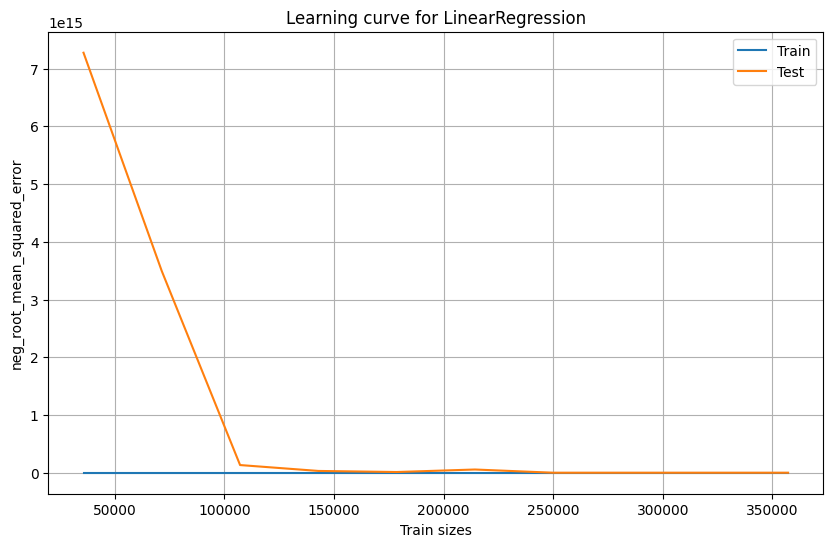

In [64]:
# Graficar curvas de aprendizaje para RMSE
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Elección del mejor modelo
best_model = models["LinearRegression"]


# Función para graficar curvas de aprendizaje
def plot_learning_curve(
    model, X, y, cv, scoring, train_sizes=np.linspace(0.1, 1.0, 10)
):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=-1,
        shuffle=True,
        random_state=42,
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Convertir métrica a positiva si es necesario
    if "neg_" in scoring:
        train_scores_mean = -train_scores_mean
        test_scores_mean = -test_scores_mean

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Train")
    plt.plot(train_sizes, test_scores_mean, label="Test")
    plt.xlabel("Train sizes")
    plt.ylabel(scoring)
    plt.title(f"Learning curve for {model.__class__.__name__}")
    plt.legend()
    plt.grid()
    plt.show()


# Curva de aprendizaje con RMSE
plot_learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
)

## Predicciones

In [65]:
############### Predicciones ###############
from sklearn.metrics import mean_squared_error  # RMSE debe colocar squared=False
from sklearn.metrics import mean_absolute_error, r2_score

# Predicciones
y_pred = best_model.predict(X_test)

print(
    f"RMSE(test) = {mean_squared_error(y_test, y_pred, squared=False):.4f} en un conjunto de {len(y_test)} observaciones"
)

print(
    f"MAE(test) = {mean_absolute_error(y_test, y_pred):.4f} en un conjunto de {len(y_test)} observaciones"
)
print(
    f"R2(test) = {r2_score(y_test, y_pred):.4f} en un conjunto de {len(y_test)} observaciones"
)

# Tabla de importancia de variables
if best_model == models["LinearRegression"]:  # Si es regresión lineal
    importancia = best_model.coef_
    nombres = X_train.columns
    df_importancia = pd.DataFrame(
        {
            "Variable": nombres,
            "Importancia": importancia,
            "Intercepto": best_model.intercept_,
        }
    )
    df_importancia = df_importancia.sort_values("Importancia", ascending=False)
    df_importancia
else:
    importancia = best_model.feature_importances_  # Si es otro modelo
    nombres = X_train.columns
    df_importancia = pd.DataFrame({"Variable": nombres, "Importancia": importancia})
    df_importancia = df_importancia.sort_values("Importancia", ascending=False)
    df_importancia

print(df_importancia.head(50))

RMSE(test) = 1641899.9164 en un conjunto de 191331 observaciones
MAE(test) = 203583.7950 en un conjunto de 191331 observaciones
R2(test) = 0.2375 en un conjunto de 191331 observaciones
                                             Variable   Importancia  \
49                             ENF_CARDIOVASCULAR_1.0  7.104520e+15   
48                             ENF_CARDIOVASCULAR_0.0  7.104520e+15   
1                                              Sexo_M  1.129809e+13   
0                                              Sexo_F  1.129809e+13   
37  Reclamacion_Desc_TRATAMIENTO QUIRURGICO HOSPIT... -1.546034e+13   
17                Reclamacion_Desc_ATENCION DEL PARTO -1.546035e+13   
27                        Reclamacion_Desc_FUNERARIOS -1.546035e+13   
36   Reclamacion_Desc_TRATAMIENTO MEDICO HOSPITALARIO -1.546035e+13   
24                          Reclamacion_Desc_DIALISIS -1.546035e+13   
32                              Reclamacion_Desc_PAMD -1.546035e+13   
19               Reclamacion_Desc_

In [66]:
# Exportar modelo a csv para usar en el dashboard
df_importancia.to_csv(
    "data/df_importancia_p.csv", index=False, sep=";", decimal=",", encoding="utf-8 sig"
)

In [67]:
df.sample(1)

,Sexo,rango_edad,Regional_desc,target,Reclamacion_Desc,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR
521114,M,1-12,REGIONAL OCCIDENTE,85312.0,CONSULTA EXTERNA,0.0,0.0,0.0,0.0,0.0


# Expuestos

In [190]:
# Crear columna llamada expuestos que sea la suma de los usuarios que tengan exactamente las mismas caracteristicas en todas las columnas
df1["expuestos"] = df1.groupby(
    [
        "Sexo",
        "rango_edad",
        "Regional_desc",
        "Reclamacion_Desc",
        "CANCER",
        "EPOC",
        "DIABETES",
        "HIPERTENSION",
        "ENF_CARDIOVASCULAR",
    ]
)["Afiliado_Id"].transform("nunique")

# Eliminar columna target
df1 = df1.drop(
    [
        "target",
        "Afiliado_Id",
    ],
    axis=1,
)

# Eliminar duplicados
df1 = df1.drop_duplicates()


# Los que en cancer dicen 1 cambiar a "SI CANCER", los que dicen 0 cambiar a "NO CANCER"
df1["CANCER"] = df1["CANCER"].replace(1, "SI CANCER")
df1["CANCER"] = df1["CANCER"].replace(0, "NO CANCER")

df1["EPOC"] = df1["EPOC"].replace(1, "SI EPOC")
df1["EPOC"] = df1["EPOC"].replace(0, "NO EPOC")

df1["DIABETES"] = df1["DIABETES"].replace(1, "SI DIABETES")
df1["DIABETES"] = df1["DIABETES"].replace(0, "NO DIABETES")

df1["HIPERTENSION"] = df1["HIPERTENSION"].replace(1, "SI HIPERTENSO")
df1["HIPERTENSION"] = df1["HIPERTENSION"].replace(0, "NO HIPERTENSO")

df1["ENF_CARDIOVASCULAR"] = df1["ENF_CARDIOVASCULAR"].replace(
    1, "SI ENF CARDIOVASCULAR"
)
df1["ENF_CARDIOVASCULAR"] = df1["ENF_CARDIOVASCULAR"].replace(
    0, "NO ENF CARDIOVASCULAR"
)

# Donde diga F cambiar a FEMENINO, donde diga M cambiar a MASCULINO
df1["Sexo"] = df1["Sexo"].replace("F", "FEMENINO")
df1["Sexo"] = df1["Sexo"].replace("M", "MASCULINO")


# Exportar csv
df1.to_csv("data/expuestos.csv", index=False, sep=";", decimal=",")

In [184]:
# ver los registros de rango_edad 60-69 y masculino, regional occidente y consulta de urgencias
df1.loc[
    (df1["rango_edad"] == "60-69")
    & (df1["Sexo"] == "MASCULINO")
    & (df1["Regional_desc"] == "REGIONAL OCCIDENTE")
    & (df1["Reclamacion_Desc"] == "CONSULTA DE URGENCIAS")
]

,Sexo,rango_edad,Regional_desc,Reclamacion_Desc,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,expuestos
41,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,NO CANCER,NO EPOC,NO DIABETES,NO HIPERTENSO,NO ENF CARDIOVASCULAR,190
500,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,NO CANCER,NO EPOC,NO DIABETES,SI HIPERTENSO,NO ENF CARDIOVASCULAR,115
10961,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,NO CANCER,NO EPOC,SI DIABETES,SI HIPERTENSO,NO ENF CARDIOVASCULAR,22
11795,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,SI CANCER,NO EPOC,SI DIABETES,SI HIPERTENSO,NO ENF CARDIOVASCULAR,3
12053,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,SI CANCER,NO EPOC,NO DIABETES,NO HIPERTENSO,NO ENF CARDIOVASCULAR,22
25524,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,NO CANCER,NO EPOC,NO DIABETES,SI HIPERTENSO,SI ENF CARDIOVASCULAR,10
48578,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,SI CANCER,NO EPOC,NO DIABETES,SI HIPERTENSO,NO ENF CARDIOVASCULAR,11
52008,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,NO CANCER,NO EPOC,SI DIABETES,NO HIPERTENSO,NO ENF CARDIOVASCULAR,5
56479,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,NO CANCER,NO EPOC,SI DIABETES,SI HIPERTENSO,SI ENF CARDIOVASCULAR,4
68803,MASCULINO,60-69,REGIONAL OCCIDENTE,CONSULTA DE URGENCIAS,SI CANCER,NO EPOC,NO DIABETES,SI HIPERTENSO,SI ENF CARDIOVASCULAR,3


Para sacar los expuestos agrupamos los usuarios que cumplen las siguientes condiciones:"Sexo","rango_edad","Regional_desc", "Reclamacion_desc","CANCER","EPOC","DIABETES","HIPERTENSION","ENF_CARDIOVASCULAR"

# Optimización de hiperparámetros

In [12]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import numpy as np

# Definir el espacio de búsqueda
space = {
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "n_estimators": hp.choice("n_estimators", [100, 200, 300]),
    "max_depth": hp.choice("max_depth", [3, 6, 9]),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
}


# Definir la función objetivo
def objective(space):
    model = xgb.XGBRegressor(
        learning_rate=space["learning_rate"],
        n_estimators=int(space["n_estimators"]),
        max_depth=int(space["max_depth"]),
        subsample=space["subsample"],
        colsample_bytree=space["colsample_bytree"],
    )

    # Calcular el RMSE medio a través de la validación cruzada de 5 pliegues
    scores = cross_val_score(
        model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error"
    )
    rmse = -scores.mean()

    return {"loss": rmse, "status": STATUS_OK}


# Ejecutar la optimización
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
)

print(best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [50:22<00:00, 30.22s/trial, best loss: 2.6497189273496686]
{'colsample_bytree': 0.727111540631194, 'learning_rate': 0.043510496859195225, 'max_depth': 0, 'n_estimators': 1, 'subsample': 0.8652461409001582}


In [199]:
# Fit en el mejor modelo
best_model = xgb.XGBRegressor(
    learning_rate=best["learning_rate"],
    n_estimators=200,
    max_depth=3,
    subsample=best["subsample"],
    colsample_bytree=best["colsample_bytree"],
    random_state=42,
)

best_model.fit(X_train, y_train)

# Predicciones
y_pred = best_model.predict(X_test)

print(
    f"RMSE(test) = {mean_squared_error(y_test, y_pred, squared=False):.4f} en un conjunto de {len(y_test)} observaciones"
)

print(
    f"MAE(test) = {mean_absolute_error(y_test, y_pred):.4f} en un conjunto de {len(y_test)} observaciones"
)
print(
    f"R2(test) = {r2_score(y_test, y_pred):.4f} en un conjunto de {len(y_test)} observaciones"
)

# Tabla de importancia de variables
if best_model == models["LinearRegression"]:  # Si es regresión lineal
    importancia = best_model.coef_
    nombres = X_train.columns
    df_importancia = pd.DataFrame(
        {
            "Variable": nombres,
            "Importancia": importancia,
            "Intercepto": best_model.intercept_,
        }
    )
    df_importancia = df_importancia.sort_values("Importancia", ascending=False)
    df_importancia
else:
    importancia = best_model.feature_importances_  # Si es otro modelo
    nombres = X_train.columns
    df_importancia = pd.DataFrame({"Variable": nombres, "Importancia": importancia})
    df_importancia = df_importancia.sort_values("Importancia", ascending=False)
    df_importancia

print(df_importancia.head(50))

RMSE(test) = 1878437.1249 en un conjunto de 191331 observaciones
